# Model results

Let's see what these models output. Reader is assumed to have gone through the preceding notebooks.

In [1]:
%run imports.py
from modelinter.preprocessing.imports_load_data import read_csvs, extract_arrays
raw_data = read_csvs()
arrays = extract_arrays(raw_data)

/home/orazio/.virtualenvs/model_interconnectedness_36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## evaluate model results

Now we will evaluate the loss of a portfolio composed by N stocks and N options: 

$L_t^s = \sum_i^N w_i^s r_{it} \\
L_t^o =  \sum_i^N w_i^0 c_{it} \\
L_t = L_t^s + L_t^o$

during the severely adverse FED CCAR scenario. Here $r_{it} = r(I_t)$ is the return of the stock calculated according to the models, a function of $I_t$ the return on the SP500 index. $c_{it} = r(J_t, r_{it})$ is the return of the option, with $J_t$ being the level of VIX at time $t$. The weights are calculated according to:

$w_i^s = w_i^o = 100/(S_{0i} + C_{0i}),$

i.e. every stock-option pair is weighted inversely proportional to its price at time 0, so that the full value of each portfolio at time 0 is exactly 100 and the highest priced asset pairs do not dominate the portfolio.

We'll substitute the Note that CCAR only publishes values for Dow Jones in their scenarions. We'll assume that the returns on Dow Jones are the same as those on S&P.

Let's ealuate the models' parameters

In [2]:
from modelinter.models.calculations import eval_PGM, DefaultSettings
PGM = eval_PGM(arrays, DefaultSettings)

/home/orazio/.virtualenvs/model_interconnectedness_36/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/home/orazio/.virtualenvs/model_interconnectedness_36/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/home/orazio/.virtualenvs/model_interconnectedness_36/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/orazio/.virtualenvs/model_interconnectedness_36/lib/python3.6/site-packages/numpy/linalg/linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


Now we'll calculate some values that we need for the scenario:
* `scenario.N` = number of stocks
* `scenario.t` = timestamps for quarters of CCAR scenario
* `scenario.dow_t` = returns of SP500 at time t according to CCAR
* `scenario.vix_t` = value of VIX at time t according to CCAR
* `scenario.stock_prices_t0`, `scenario.options_prices_t0` = prices of stocks and options at time

plus the weights for stocks and options respectively

In [3]:
from modelinter.models.calculations import extract_scenario, calc_weights


In [4]:
scenario = extract_scenario(arrays=arrays,
                            raw_data=raw_data,
                            options_model=PGM.PGM_options_A,
                            settings=DefaultSettings)
weights = calc_weights(scenario.stock_prices_t0, scenario.options_prices_t0)

Now we'll sample the output of the models. This piece of code checks whether the calculation has been done already and if so, it doesn't repeat it.

`sample_results` is a function that loops over all the quarters of the CCAR scenario, sampling portfolio values for each quarter, and returns a list of sampled values for each portfolio for each quarter.

`sample_results` actually calls on a function called `price_portfolio`, that hard-codes the hypotheses we did on our scenario. `price_portfolio` calls on two other functions, each encoding the hypotheses on the stocks and options portfolio respectively.

In [5]:
from modelinter.models.calculations import price_portfolio, stocks_pricing, options_pricing
view_code(price_portfolio); view_code(stocks_pricing); view_code(options_pricing)

In file: ../../modelinter/models/calculations.py


def price_portfolio(dow_t, vix_t, model_stock, model_options, date, weights, scenario, samples=1):
    """prices the whole combined portfolio of stocks and options"""
    # let's make a function that gives us the value of the portfolio
    # at a certain date.
    days = countdays(scenario.t[0], date)
    # predict stocks
    stocks = stocks_pricing(dow_t, model_stock, days, samples=samples, scenario=scenario)
    # predict and weight options
    options = weights.options_weights * options_pricing(vix_t=vix_t, stock_prices_t=stocks, model=model_options, days=days,
                                              samples=samples, settings=DefaultSettings)
    # weight stocks
    stocks = weights.stock_weights * stocks
    if samples == 1:
        return stocks, options
    else:
        return [_ for _ in stocks], [_ for _ in options]

In file: ../../modelinter/models/calculations.py


def stocks_pricing(dow_t, model, days, samples, scenar

In [6]:
from modelinter.models.calculations import sample_results
from os.path import isfile #check file existence
from modelinter.models.constants import Paths #where is the file
from modelinter.models.utils import Pkl #read/write pickle files

# if results have already been calculated and saved:
if isfile(Paths.SAVE_DIR.value + 'results' + Paths.PKL_EXT.value) and not DefaultSettings.recalculate_results:
    # load pickled results
    results = Pkl.load(Paths.SAVE_DIR.value + 'results' + Paths.PKL_EXT.value)
else:
    # sample the results
    # code: L_[Stock or Option][PGM A, B or C]
    # one_s, one_o = 1000 samples each for first 50 option-stock pair
    results = sample_results(scenario, weights, PGM,
                             DefaultSettings.samples)
    if DefaultSettings.save_results:
        # pickle results
        Pkl.save(results,
                 Paths.SAVE_DIR.value + 'results' + Paths.PKL_EXT.value)


Now let's look at the results.

In [7]:
from modelinter.models.utils import draw_plot
from modelinter.models.model_results import \
    plot_correlation, \
    plot_stocks_portfolio_distribution, \
    plot_options_portfolio_distribution, \
    print_skew, print_skew_stocks, plot_scenario, \
    plot_stocks_portfolio, plot_options_portfolio, \
    plot_combined_portfolios, plot_models_interaction
from modelinter.models.model_results import\
    plot_paper_correlations, plot_paper_scenarios

Let's look at the correlation between stock and options models output.

<IPython.core.display.Javascript object>


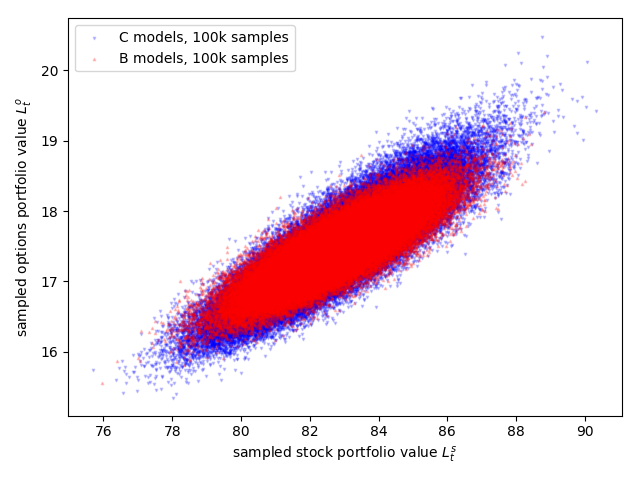

In [8]:
draw_plot(plot_correlation,
          {'results': results,
           'quarter': 10
           },
          nb = True)

Let's look at the distribution of stock portfolio values. We should expect a gaussian but it's actually a slightly asymmetric distribution, skewed towards the right of the mean. this is because some of the stocks, during the worse quarter of the CCAR scenario, are priced at about 0. When sampling prices for the stocks in this situation, some prices are sampled below zero: in `stocks_pricing()` we added a line that values a stock at 1 cent if its price is sampled at or below 0.

<IPython.core.display.Javascript object>


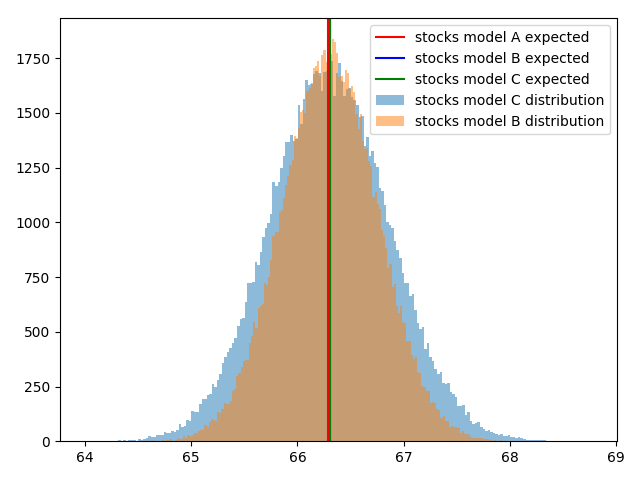

In [11]:
draw_plot(plot_stocks_portfolio_distribution,
          {'results': results,
           'quarter': 1,
           'bins': 200
           },
          nb = True)

The distribution is skewed.

In [12]:
print_skew_stocks(results, quarter=1)

skewness and 2*std of a similarly-sized normal distribution 
 -0.00157865874619 0.00932002928595 
 skewness of PGM B stock portfolio distribution 
 0.003486499627180976 
 skewness of PGM C stock portfolio distribution 
 0.040573587087527355


Let's look instead at the distributions of the options portfolio. It's much more interesting

<IPython.core.display.Javascript object>


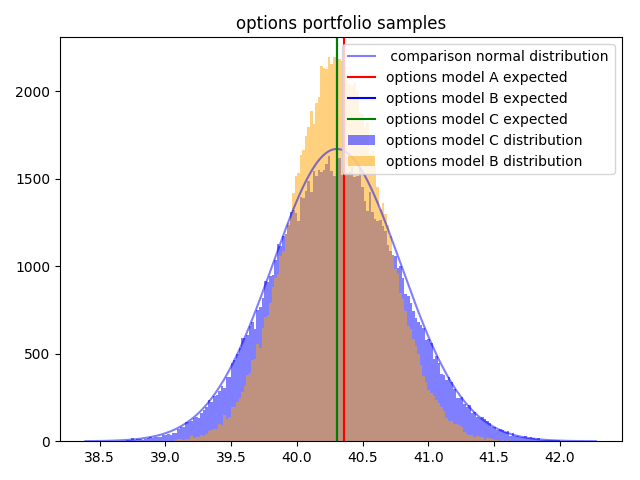

In [14]:
draw_plot(plot_options_portfolio_distribution,
          {'results': results,
           'quarter': 1,
           'bins': 200
           },
          nb = True)

Notice how the distribution of sampled portfolio prices is slightly skewed to the right. This is due to the nonlinearity of the Black-Scholes formula, that causes an asymmetric distribution. This causes the A model to predict an expected value that is different from that of B and C models!

In [15]:
print_skew(results, quarter=4)

skewness and 2*std of a similarly-sized normal distribution 
 0.00430023985295 0.006086182162 
 skewness of PGM B options portfolio distribution 
 0.04365170633387621 
 skewness of PGM C options portfolio distribution 
 0.26911520082725526


Now, before looking at how portfolios evolve in time, plot the CCAR scenario over time

<IPython.core.display.Javascript object>


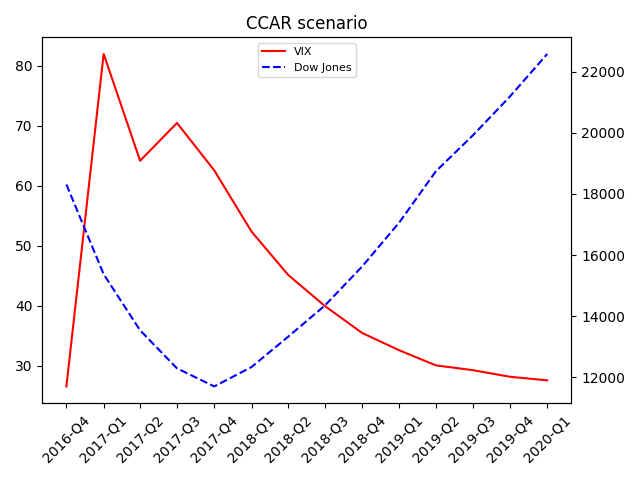

In [16]:
draw_plot(plot_scenario,
          {'scenario': scenario,
           'settings': DefaultSettings
           },
          nb = True)

Let's plot the predicted values for the stocks portfolio. Note that the skewed distribution here produces different expected values for PGMS A and (B,C) respectively

<IPython.core.display.Javascript object>


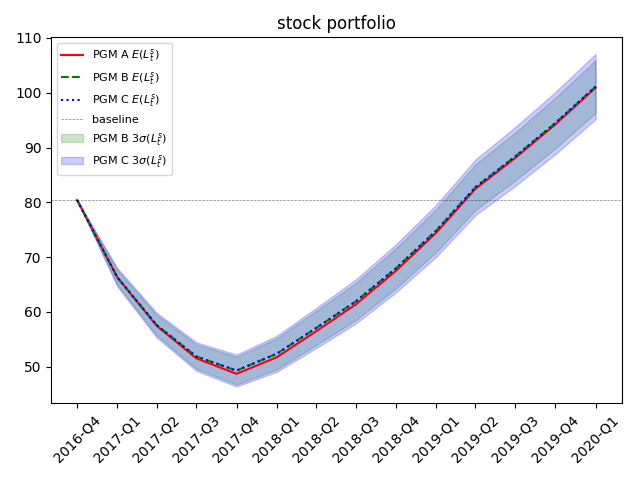

In [18]:
draw_plot(plot_stocks_portfolio,
          {'scenario': scenario,
           'results': results
           },
          nb = True)

Let's plot the predictions for the options portfolio. Note the difference betweeen expected value for model A and models B,C. This is because of the asymmetric distribution, as discussed above.

<IPython.core.display.Javascript object>


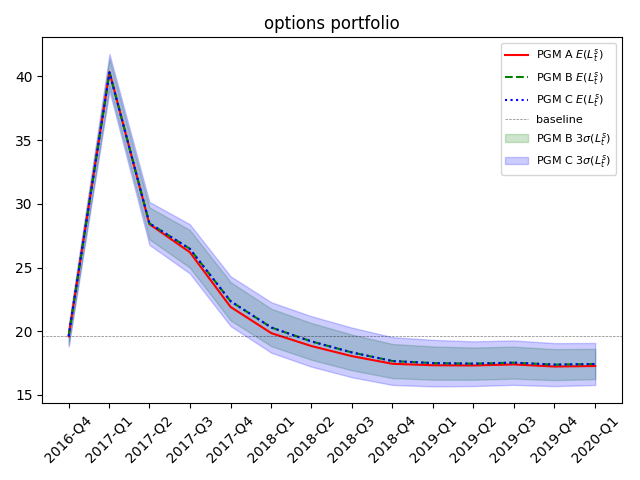

In [19]:
draw_plot(plot_options_portfolio,
          {'scenario': scenario,
           'results': results
           },
          nb = True)

Plot of the combined portfolios. The standard deviation of the combined portfolios is higher! This is because the two models are positively correlated, so you have to include a term in the joint distribution of losses.

<IPython.core.display.Javascript object>


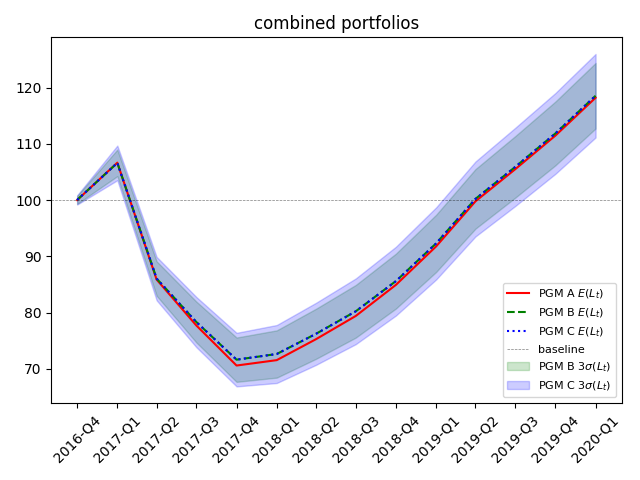

In [20]:
draw_plot(plot_combined_portfolios,
          {'scenario': scenario,
           'results': results
           },
          nb = True)

Finally, let's look at the ratio between standard deviation predicted by the models and the value of the portfolios. The normalization to the value is needed because they have wildly different values, and they would not be comparable otherwise.

<IPython.core.display.Javascript object>


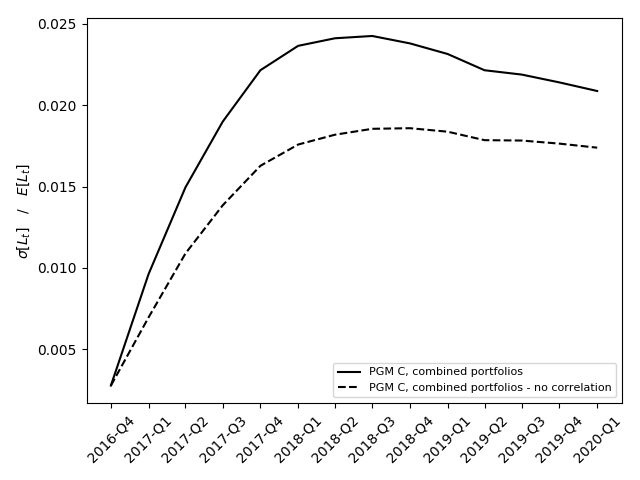

In [21]:
draw_plot(plot_models_interaction,
          {'scenario': scenario,
           'results': results
           },
          nb = True)

Let's plot the paper's figures

In [24]:
from modelinter.models.utils import show_figure

<IPython.core.display.Javascript object>


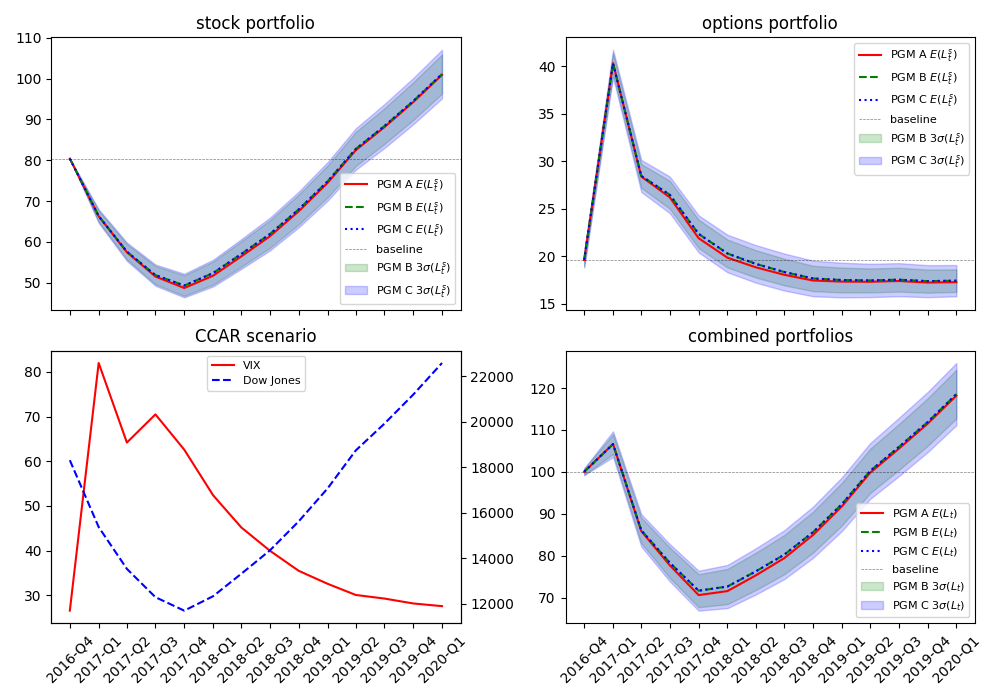

In [25]:
fig = plot_paper_scenarios(results, scenario, DefaultSettings)
show_figure(fig, nb=True)

<IPython.core.display.Javascript object>


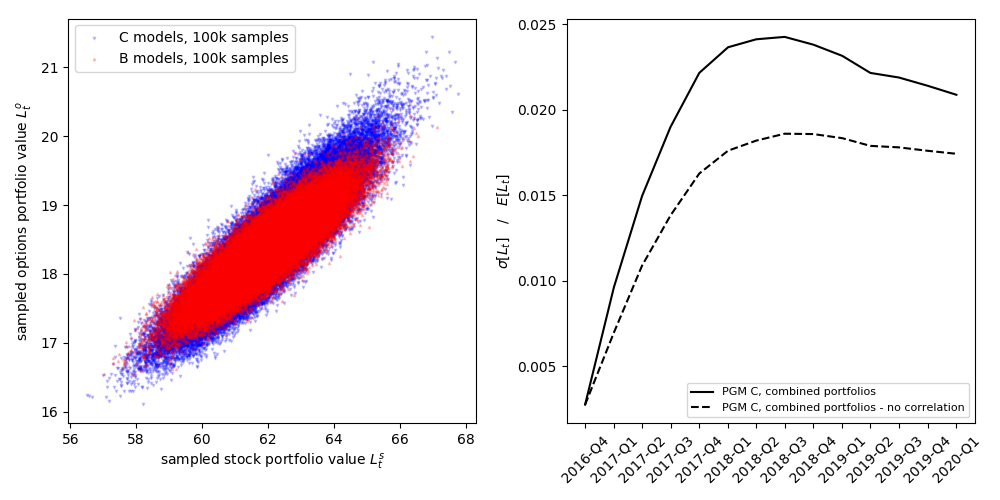

In [26]:
fig = plot_paper_correlations(results, scenario, quarter=7)
show_figure(fig,nb=True)